<div class="frontmatter text-center">
<h1> Introduction to Data Science and Programming</h1>
<h2>Lecture 18: Making code faster</h2>
<h3>IT University of Copenhagen, Fall 2020</h3>
    <h3>Instructor: Michael Szell</h3>
</div>

# Source
This notebook was adapted from:
* https://towardsdatascience.com/speed-up-jupyter-notebooks-20716cbe2025
* https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html
* https://people.duke.edu/~ccc14/sta-663/MakingCodeFast.html

## Premature Optimization Is the Root of All Evil

Donald Knuth: *Programmers waste enormous amounts of time thinking about, or worrying about, the speed of noncritical parts of their programs, and these attempts at efficiency actually have a strong negative impact when debugging and maintenance are considered. We should forget about small efficiencies, say about 97% of the time: premature optimization is the root of all evil. Yet we should not pass up our opportunities in that critical 3%.*

Correct order of steps when writing a program:
1. **Make it work**: Write the code in a simple legible way.
2. **Make it right**: Write test cases, make really sure that your algorithm is right and that if you break it, the tests will capture the breakage.
3. **Make it fast**: Optimize the code by profiling simple use-cases to find the bottlenecks and speeding up these bottlenecks, finding a better algorithm or implementation.

### Making it fast is the LAST step
and you should only optimize when it is necessary. Also, it is good to know when a program is “fast enough” for your needs. Optimization has a price:

* Cost in programmer time
* Optimized code is often more complex
* Optimized code is often less generic

However, having fast code is often necessary for statistical computing, so we will spend some time learning how to make code run faster.

### Super-advanced example of code optimization: Fast inverse square root
3D-games and simulators need billions of real-time inverse square root $\frac{1}{\sqrt{x}}$ calculations for lighting and shading:
<img src="files/surfacenormal.png" width=220px> <img src="files/openarena.jpg" width=220px>

Instead of doing `(float)(1.0/sqrt(x))`, this C++ code was developed in the 1980s/1990s (original comments):

```c++
float Q_rsqrt( float number )
{
	long i;
	float x2, y;
	const float threehalfs = 1.5F;

	x2 = number * 0.5F;
	y  = number;
	i  = * ( long * ) &y;                       // evil floating point bit level hacking
	i  = 0x5f3759df - ( i >> 1 );               // what the fuck? 
	y  = * ( float * ) &i;
	y  = y * ( threehalfs - ( x2 * y * y ) );   // 1st iteration
//	y  = y * ( threehalfs - ( x2 * y * y ) );   // 2nd iteration, this can be removed

	return y;
}
```

It avoids division and is 4 times faster. This is a significant speed-up for millions of real-time calculations every second.
More details: 
https://en.wikipedia.org/wiki/Fast_inverse_square_root

https://betterexplained.com/articles/understanding-quakes-fast-inverse-square-root/

Warning - advanced math: http://www.lomont.org/papers/2003/InvSqrt.pdf

### Code can be slow for different reasons

* **CPU-bound** - CPU is working flat out
* **Memory-bound** - Out of RAM - swapping to hard disk
* **IO-bound** - Lots of data transfer to and from hard disk
* **Network-bound** - CPU is waiting for data to come over network or from memory (“starvation”)

## There is a natural order of making code fast
1. Cheat: Use sample data, solve a simpler problem, buy more RAM, etc.
2. **Profile**: Find out the bottlenecks
3. **Use better algorithms and data structures**
4. Using compiled code written in another language
5. Converting Python code to compiled code
6. Parallelize programs / execute in parallel

# Profiling and timing code
There is no optimization without measuring! Do not rely on "theorycrafting" - just measure it.

### Magic commands for Jupyter

* `%time`: Time the execution of a single statement
* `%timeit`: Time repeated execution of a single statement for more accuracy
* `%prun`: Run code with the profiler
* `%lprun`: Run code with the line-by-line profiler
* `%memit`: Measure the memory use of a single statement
* `%mprun`: Run code with the line-by-line memory profiler

The last 3 commands are not bundled with Jupyter – you'll need to get the `line_profiler` and `memory_profiler` extension.

Also we use:

* `%%heat`
* `snakeviz`: visualizing the output of a profiling session

## Timing Code Snippets: ``%timeit`` and ``%time``

The ``%timeit`` line-magic and ``%%timeit`` cell-magic can be used to time the repeated execution of snippets of code:

In [4]:
%timeit sum(range(100))

829 ns ± 1.92 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Because this operation is so fast, ``%timeit`` automatically does a large number of repetitions.

For slower commands, ``%timeit`` will automatically adjust and perform fewer repetitions:

In [6]:
%%timeit
total = 0
for i in range(1000):
    for j in range(1000):
        total += i * (-1) ** j

357 ms ± 889 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Sometimes repeating an operation is not the best option.
For example, if we have a list that we'd like to sort, we might be misled by a repeated operation.
Sorting a pre-sorted list is much faster than sorting an unsorted list, so the repetition will skew the result:

In [7]:
import random
L = [random.random() for i in range(100000)]
%timeit L.sort()

816 µs ± 45.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


For this, the ``%time`` magic function may be a better choice. It also is a good choice for longer-running commands, when short, system-related delays are unlikely to affect the result.
Let's time the sorting of an unsorted and a presorted list:

In [8]:
import random
L = [random.random() for i in range(100000)]
print("sorting an unsorted list:")
%time L.sort()

sorting an unsorted list:
CPU times: user 20.1 ms, sys: 487 µs, total: 20.6 ms
Wall time: 20.6 ms


In [9]:
print("sorting an already sorted list:")
%time L.sort()

sorting an already sorted list:
CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 2.02 ms


Wall time is the time that a clock on the wall would measure as having elapsed between the start of the process and 'now'.

The CPU times is the amount of time spent of the CPUs (can be much more than wall time if multi-core, for example).

The presorted list is much faster to sort. Notice also how much longer the timing takes with ``%time`` versus ``%timeit``, even for the presorted list! ``%timeit`` does some clever things under the hood to prevent system calls from interfering with the timing. For this reason, ``%timeit`` results are usually noticeably faster than ``%time`` results.

For ``%time`` as with ``%timeit``, using the double-percent-sign cell magic syntax allows timing of multiline scripts:

In [11]:
%%time
total = 0
for i in range(1000):
    for j in range(1000):
        total += i * (-1) ** j

CPU times: user 437 ms, sys: 3.96 ms, total: 441 ms
Wall time: 441 ms


In [18]:
%time?

Docstring:
Time execution of a Python statement or expression.

The CPU and wall clock times are printed, and the value of the
expression (if any) is returned.  Note that under Win32, system time
is always reported as 0, since it can not be measured.

This function can be used both as a line and cell magic:

- In line mode you can time a single-line statement (though multiple
  ones can be chained with using semicolons).

- In cell mode, you can time the cell body (a directly
  following statement raises an error).

This function provides very basic timing functionality.  Use the timeit
magic for more control over the measurement.

.. versionchanged:: 7.3
    User variables are no longer expanded,
    the magic line is always left unmodified.

Examples
--------
::

  In [1]: %time 2**128
  CPU times: user 0.00 s, sys: 0.00 s, total: 0.00 s
  Wall time: 0.00
  Out[1]: 340282366920938463463374607431768211456L

  In [2]: n = 1000000

  In [3]: %time sum(range(n))
  CPU times: user 1.20 s,

For more information on ``%time`` and ``%timeit``, as well as their available options, use the IPython help functionality (i.e., type ``%time?`` at the IPython prompt).

## Timing outside of Jupyter

In [19]:
from timeit import default_timer as timer

start = timer()
sum(range(100))
end = timer()
print(end - start)

7.301000005099922e-05


In [20]:
import time

start = time.perf_counter()
sum(range(100))
end = time.perf_counter()
print(end - start)

6.76180025038775e-05


## Profiling and Optimizing: Monte Carlo method example

We get the value of pi by taking the ratio of area of circle to area of the square:
<img src="files/montecarlo01.png" width=400px>

where we approximate the area with generated random points, $\frac{\mathrm{area\, of\, circle}}{\mathrm{area\, of\, square}} \approx \frac{\mathrm{points\, in\, circle}}{\mathrm{points\, in\, square}}$
<img src="files/montecarlo02.png" width=400px>

In [22]:
from random import random

def estimate_pi(n = 10000000):
    """Estimate pi with monte carlo simulation."""
    in_circle = 0
    total = n
    
    while n != 0:
        prec_x = random()
        prec_y = random()
        if pow(prec_x, 2) + pow(prec_y, 2) <= 1: # circle equation: x^2+y^2=r^2
            in_circle += 1 # inside the circle
        n -= 1
        
    return 4 * in_circle / total

In [23]:
%time estimate_pi()

CPU times: user 3.67 s, sys: 19.6 ms, total: 3.69 s
Wall time: 3.71 s


3.1413092

From now on, lets normalize this and run `%timeit` always with the same parameters:

In [24]:
%timeit -r 2 -n 5 estimate_pi()

3.69 s ± 3.07 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)


### cProfile
To learn what takes up most of the execution time, python ships with a great profiler, cProfile, breaking down the execution function by function. It causes our attention to shrink down to critical functions by handing out a high-level view of performance. In Jupyer, use the [`%prun`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-prun) magic:

In [25]:
%prun estimate_pi()

         40000004 function calls in 9.308 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    5.446    5.446    9.308    9.308 <ipython-input-22-6c583bd19c05>:3(estimate_pi)
 20000000    2.366    0.000    2.366    0.000 {built-in method builtins.pow}
 20000000    1.496    0.000    1.496    0.000 {method 'random' of '_random.Random' objects}
        1    0.000    0.000    9.308    9.308 {built-in method builtins.exec}
        1    0.000    0.000    9.308    9.308 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

The output will be written to stdout:<img src="files/profiling.png" width=1000>

The report shows for each function:
* the number of calls (ncalls)
* the total time (tottime) spent on it excluding calls to subfunctions
* how long each call took (percall, excluding and including)
* the total time (cumtime) including all calls to subfunctions

An another useful option is -s which enables sorting for a particular column. For example sorting cumulative time in descending order:

In [26]:
%prun -s cumulative estimate_pi()

         40000004 function calls in 9.508 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    9.508    9.508 {built-in method builtins.exec}
        1    0.000    0.000    9.508    9.508 <string>:1(<module>)
        1    5.555    5.555    9.508    9.508 <ipython-input-22-6c583bd19c05>:3(estimate_pi)
 20000000    2.417    0.000    2.417    0.000 {built-in method builtins.pow}
 20000000    1.536    0.000    1.536    0.000 {method 'random' of '_random.Random' objects}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

If we wish to save the output for later inspection for example with [pstats](https://docs.python.org/3.7/library/profile.html#the-stats-class), use the -D option to save on disk. 

You can also just return the stats object with the -r option:

In [27]:
stats = %prun -r -q estimate_pi()

In [28]:
stats.sort_stats('tottime').print_stats(3);

         40000004 function calls in 9.508 seconds

   Ordered by: internal time
   List reduced from 6 to 3 due to restriction <3>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    5.576    5.576    9.508    9.508 <ipython-input-22-6c583bd19c05>:3(estimate_pi)
 20000000    2.409    0.000    2.409    0.000 {built-in method builtins.pow}
 20000000    1.523    0.000    1.523    0.000 {method 'random' of '_random.Random' objects}




The number of calls to built-in functions `pow()` and `random()` seems to take some time. Before we address this extensive number of calls, let’s have a look at a much more convenient library delivering even more concrete reports.

### Line profiler
The `%lprun` command yields the time spent on each line of code giving us a line by line report. Since not shipped by default, install the library

```bash
conda install line_profiler 
```

and load the extension manually in the notebook.

```python
%load_ext line_profiler
```

In [29]:
%load_ext line_profiler

In [30]:
stats_lprun = %lprun -r -f estimate_pi estimate_pi()

Timer unit: 1e-06 s

Total time: 22.6265 s
File: <ipython-input-22-6c583bd19c05>
Function: estimate_pi at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def estimate_pi(n = 10000000):
     4                                               """Estimate pi with monte carlo simulation."""
     5         1          2.0      2.0      0.0      in_circle = 0
     6         1          1.0      1.0      0.0      total = n
     7                                               
     8  10000001    3253513.0      0.3     14.4      while n != 0:
     9  10000000    3363210.0      0.3     14.9          prec_x = random()
    10  10000000    3276161.0      0.3     14.5          prec_y = random()
    11  10000000    6264824.0      0.6     27.7          if pow(prec_x, 2) + pow(prec_y, 2) <= 1: # circle equation: x^2+y^2=r^2
    12   7853542    2803375.0      0.4     12.4              in_circle += 1 # inside the circle
    13  10000000 

In [31]:
stats_lprun.print_stats();

Timer unit: 1e-06 s

Total time: 22.6265 s
File: <ipython-input-22-6c583bd19c05>
Function: estimate_pi at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def estimate_pi(n = 10000000):
     4                                               """Estimate pi with monte carlo simulation."""
     5         1          2.0      2.0      0.0      in_circle = 0
     6         1          1.0      1.0      0.0      total = n
     7                                               
     8  10000001    3253513.0      0.3     14.4      while n != 0:
     9  10000000    3363210.0      0.3     14.9          prec_x = random()
    10  10000000    3276161.0      0.3     14.5          prec_y = random()
    11  10000000    6264824.0      0.6     27.7          if pow(prec_x, 2) + pow(prec_y, 2) <= 1: # circle equation: x^2+y^2=r^2
    12   7853542    2803375.0      0.4     12.4              in_circle += 1 # inside the circle
    13  10000000 

Notice the extensive time (~28%) spent on the if statement on line 15.

#### Visualizing the profile with heat

```bash
pip install py-heat-magic
```

and load the extension manually in the notebook:

In [32]:
%load_ext heat

This code can take a minute or two to execute:

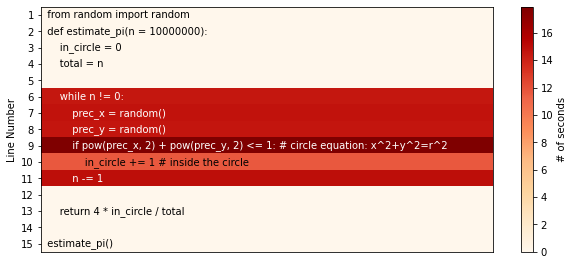

In [33]:
%%heat
from random import random
def estimate_pi(n = 10000000):
    in_circle = 0
    total = n
    
    while n != 0:
        prec_x = random()
        prec_y = random()
        if pow(prec_x, 2) + pow(prec_y, 2) <= 1: # circle equation: x^2+y^2=r^2
            in_circle += 1 # inside the circle
        n -= 1
        
    return 4 * in_circle / total

estimate_pi()

#### Visualizing the profile with snakeviz
```bash
conda install snakeviz
```

and load the extension manually in the notebook:

In [34]:
%load_ext snakeviz

In [35]:
%snakeviz estimate_pi()

 
*** Profile stats marshalled to file '/var/folders/p1/35n1p5qd3jd93mc6mmgngy400000gn/T/tmptxz_5vvz'. 
Embedding SnakeViz in this document...


<img src="files/snakeviz.png" width=350>

https://jiffyclub.github.io/snakeviz/

### Optimization

```python
def estimate_pi(n = 10000000):
    in_circle = 0
    total = n
    
    while n != 0:
        prec_x = random()
        prec_y = random()
        if pow(prec_x, 2) + pow(prec_y, 2) <= 1: # circle equation: x^2+y^2=r^2
            in_circle += 1 # inside the circle
        n -= 1
        
    return 4 * in_circle / total
```

#### Algorithmic optimization
Our code is easy to read, but slow, because of:
* while loop
* function calls: pow()

We can replace the whole function with one line!:

In [37]:
def estimate_pi_oneliner(n=1e7):
    return 4 * sum(1 for _ in range(int(n)) if random()**2 + random()**2 <= 1) / n

In [38]:
stats_oneliner = %prun -r -q estimate_pi_oneliner()

In [39]:
stats_oneliner.sort_stats('tottime').print_stats(3);

         27854379 function calls in 6.332 seconds

   Ordered by: internal time
   List reduced from 7 to 3 due to restriction <3>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  7854374    4.184    0.000    5.646    0.000 <ipython-input-37-f3fa99128393>:2(<genexpr>)
 20000000    1.463    0.000    1.463    0.000 {method 'random' of '_random.Random' objects}
        1    0.685    0.685    6.332    6.332 {built-in method builtins.sum}




In [40]:
%timeit -r 2 -n 5 estimate_pi_oneliner()

2.56 s ± 27.9 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)


From 3.67 to 2.45 seconds: Over 30% improvement!

**What did we do?**
* <span style="color:green">Replace `pow()` with `**`</span>
* <span style="color:green">Replace `while` with `sum(.. for .. in range(n))`</span>
* <span style="color:red">Made the function really hard to read for humans</span>

This is a **generator expression**: `sum(.. for .. in range(n))`

A *what??*

Iterables: Everything that you can use in a for loop. For example:

In [41]:
mylist = [0, 1, 4]
for i in mylist:
    print(i)

0
1
4


In [42]:
mylist = [x*x for x in range(3)]
for i in mylist:
    print(i)

0
1
4


Generators are iterators, but *you can only iterate over them once*. It’s because they do not store all the values in memory, they generate the values on the fly:

In [ ]:
mygenerator = (x*x for x in range(3))
for i in mygenerator:
    print(i)

In [ ]:
for i in mygenerator:
    print(i)
# Nothing happens

Generators are useful if you run into memory issues.

##### You can create a generator with yield
Yield is a keyword that is used like return, except the function will return a generator.

In [43]:
def createGenerator():
    mylist = range(3)
    for i in mylist:
        yield i*i

mygenerator = createGenerator() # create a generator
print(mygenerator) # mygenerator is an object!

for i in mygenerator:
    print(i)

<generator object createGenerator at 0x7fb9492e25f0>
0
1
4


The first time the for calls the generator object created from your function, it will run the code in your function from the beginning until it hits yield, then it’ll return the first value of the loop. Then, each other call will run the loop you have written in the function one more time, and return the next value, until there is no value to return.

#### Optimization through vectorization

All our operations are still inside the "loop":
```python
sum(1 for _ in range(int(n)) if random()**2 + random()**2 <= 1)
```
    
So we are calling `random()` 2*n times, and we call `if` n times. Do we really need to?

Vectorized version, using numpy:

In [44]:
import numpy as np

def estimate_pi_vectorized(n=10000000):
    xy = np.random.rand(n, 2)
    inside = np.sum(xy[:, 0]**2 + xy[:, 1]**2 <= 1)
    return 4 * inside / n

In [45]:
%timeit -r 2 -n 5 estimate_pi_vectorized()

290 ms ± 13.4 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)


3.67 seconds to 0.3 seconds: We are 12 times faster than in the beginning!

### Memory profiling
Juggling with large data sets involves having a clear sight of memory consumption and allocation processes going on in the background.

After installing the memory profiler,
```bash
conda install memory_profiler 
```

we can explore memory usage with `%memit`

In [46]:
%load_ext memory_profiler

In [47]:
%memit estimate_pi_vectorized()

peak memory: 411.30 MiB, increment: 152.76 MiB


This is a lot of memory. When we allocate things differently, we can reduce it:

In [48]:
def estimate_pi_vectorized_oneliner(n=10000000):
    return np.sum(np.random.random(n)**2 + np.random.random(n)**2 <= 1) / n * 4

In [49]:
%memit estimate_pi_vectorized_oneliner()

peak memory: 258.46 MiB, increment: 162.20 MiB


Also, we improved runtime:

In [50]:
%timeit -r 2 -n 5 estimate_pi_vectorized_oneliner()

195 ms ± 17.5 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)


3.67 seconds to 0.227 seconds: We are now 16 times faster than in the beginning!

#### Optimization through cheating: Running another algorithm
Using our monte carlo method, we estimated $\pi$ to 3.1426944 with a relative error of 0.035% in 227ms.

There are however different calculations tackling the issue in a substantially more productive way. The biggest lift to any programming execution will be by changing the general way of tackling the problem. Unsurprisingly, this is the hardest change to achieve as upgrade and revamp of your coding is required.

A very fast method is the [Chudnovsky algorithm](https://www.craig-wood.com/nick/articles/pi-chudnovsky/) which was published by the Chudnovsky brothers in 1989 and appears in the following form: $\frac{1}{\pi} = 12\sum_{k=0}^\infty \frac{(-1)^k(6k)!(13591409+545140134k)}{(3k)!(k!)^3 640320^{3k+3/2}}$

Profiling this method results in: 13.6 µs ± 72 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)

Which is 270,000 times faster!!! Also, we get 100 digits of pi, not just 8.

## Summary of  most effective optimization techniques

* Use better algorithms and data structures
* Avoid loops
* Vectorize (numpy)
* Avoid function calls and dot notation
* Memory: Use views, not copies
* Memory: Use generators
* Use compiled code

### Use better algorithms and data structures, avoid loops

* General explanation of time complexity: https://towardsdatascience.com/understanding-time-complexity-with-python-examples-2bda6e8158a7
* Time complexity of Python data structures: https://wiki.python.org/moin/TimeComplexity

#### Example: Unique common elements
Suppose you were given two lists `xs` and `ys` and asked to find the unique elements in common between them.

In [51]:
xs = np.random.randint(0, 1000, 10000)
ys = np.random.randint(0, 1000, 10000)

In [52]:
# This is easy to solve using a nested loop

def common1(xs, ys):
    """Using lists."""
    zs = []
    for x in xs:
        for y in ys:
            if x==y and x not in zs:
                zs.append(x)
    return zs

%timeit -n1 -r1 common1(xs, ys)

11.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [53]:
# However, it is much more efficient to use the set data structure, avoiding loops

def common2(xs, ys):
    return list(set(xs) & set(ys))

%timeit -n1 -r1 common2(xs, ys)

3.84 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Avoid function calls and dot notation

#### Example: Looped function calls
In the following example, the function `inner` is called for each element in the list. The overhead of the function call and the argument checking is multiplied 100000 times. (From https://nyu-cds.github.io/python-performance-tips/04-functions/)

In [ ]:
x = 0
def inner(i):
    global x
    x = x + i
    
def outer1():
    for i in range(100000): 
        inner(i)
        
%timeit outer1()

Here instead, the loop is moved inside the aggregate function so that the function is only called once instead of 100000 times:

In [ ]:
x = 0
def aggregate(list):
    global x
    for i in list:
        x = x + i

def outer2():
    aggregate(range(100000))
    
%timeit outer2()

#### Example: Avoid dot notation

Slow:

```python
for i in range(n):
    myObj.func(i)
```

Fast:

```python
myfunc = myObj.func
for i in range(n):
    myfunc(i)
```

## Use compiled code

### Cython
http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html

Cython is Python with C data types.

Cython is Python: Almost any piece of Python code is also valid Cython code. The Cython compiler will convert it into C code which makes equivalent calls to the Python/C API.

### Pypy
https://pypy.org/

Alternative implementaiton of Cython using a just-in-time compiler instead of an interpreter, often making it run faster.

## Optimizing code usually comes at the cost of code readability and maintainability!
Think twice if you really need to sacrifice it.

This code (from last class) might be slow to call, but is well designed and perfectly readable. If the implementation of a method if obvious like here, you did a good job in terms of object-oriented design:

```python
    def winsServe(self):
        """Returns a Boolean that is true with probability self.prob"""
        return random() <= self.prob

    def incScore(self):
        """Add a point to this player's score"""
        self.score = self.score + 1

    def getScore(self):
        """Returns this player's current score"""
        return self.score
```